In [1]:
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import GraphicalLassoCV

atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps

data = datasets.fetch_development_fmri(n_subjects=1)
fmri_filename = data.func[0]

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, verbose=5)
time_series = masker.fit_transform(fmri_filename)

X = time_series.T 

print(f"Forme de la matrice X : {X.shape}")



[fetch_atlas_msdl] Dataset found in C:\Users\victo\nilearn_data\msdl_atlas

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri\development_fmri

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri\development_fmri

[NiftiMapsMasker.wrapped] Loading regions from ...\msdl_rois.nii

[NiftiMapsMasker.wrapped] Resampling regions

[NiftiMapsMasker.wrapped] Finished fit

[NiftiMapsMasker.wrapped] Loading data from sub-pixar123_task-...

[NiftiMapsMasker.wrapped] Extracting region signals

[NiftiMapsMasker.wrapped] Cleaning extracted signals

Forme de la matrice X : (39, 168)


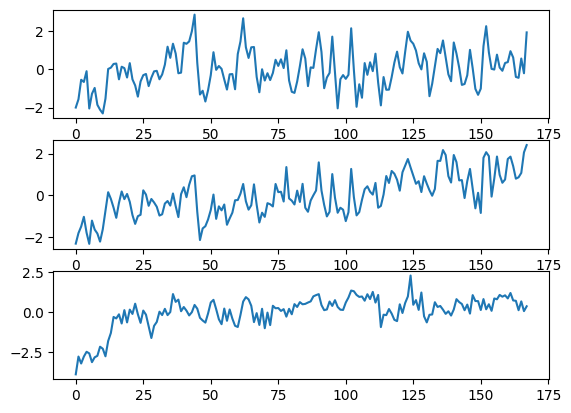

In [2]:
x0 = X[0,:]
x1 = X[1,:]
x2 = X[20,:]

plt.subplot(3,1,1)
plt.plot(x0)
plt.subplot(3,1,2)
plt.plot(x1)
plt.subplot(3,1,3)
plt.plot(x2)
plt.show()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


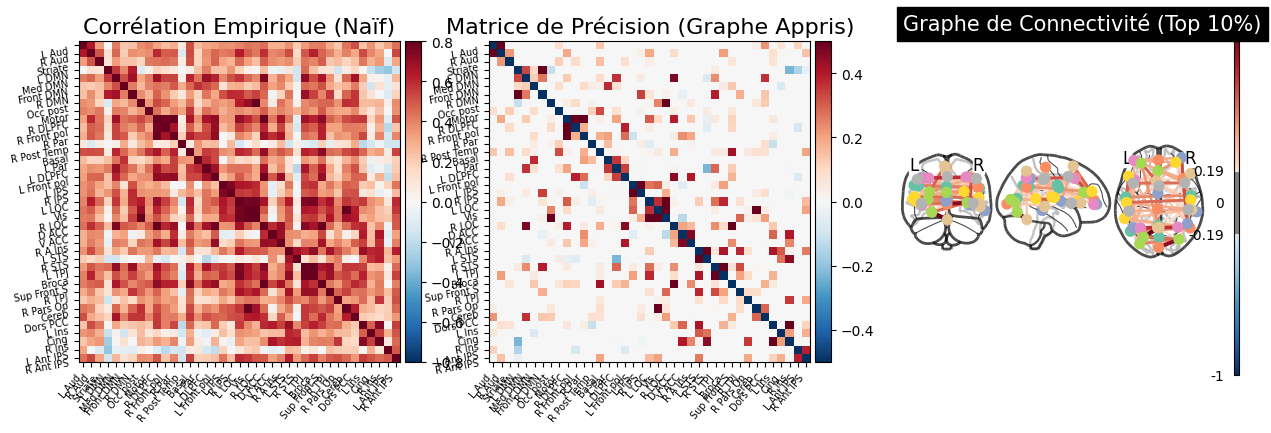

In [4]:
gl_model = GraphicalLassoCV(cv=5, max_iter=1000)
gl_model.fit(time_series)

precision_matrix = gl_model.precision_

covariance_matrix = gl_model.covariance_

coords = atlas.region_coords

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
plotting.plot_matrix(correlation_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.8, vmin=-0.8, axes=axes[0], title="Corrélation Empirique (Naïf)")

plotting.plot_matrix(-precision_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.5, vmin=-0.5, axes=axes[1], title="Matrice de Précision (Graphe Appris)")

plotting.plot_connectome(-precision_matrix, coords,
                         edge_threshold='90%', title="Graphe de Connectivité (Top 10%)",
                         axes=axes[2])

plt.show()

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1157.4985042973478
            Iterations: 13
            Function evaluations: 6682
            Gradient evaluations: 9


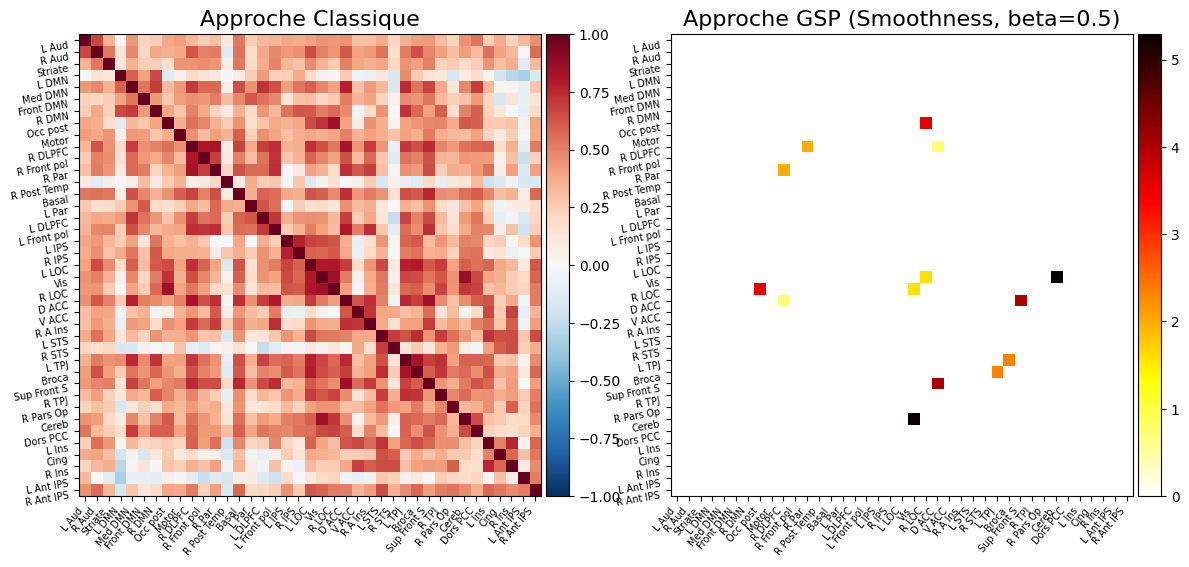

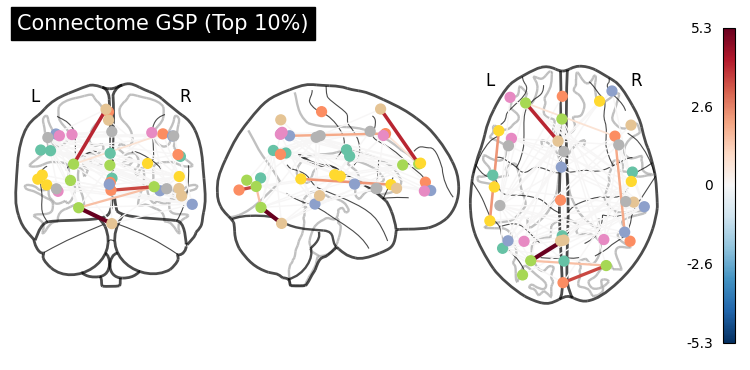

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn import plotting


X = time_series.T
n_nodes = X.shape[0]

dist_matrix_sq = squareform(pdist(X, metric='sqeuclidean'))

idx_upper = np.triu_indices(n_nodes, k=1)

def graph_learning_objective(w_vector, dist_sq, beta):
    """
    Fonction objectif : Smoothness + Régularisation
    J(L) = tr(X.T * L * X) + beta * ||L||_F^2
    """
    W = np.zeros((n_nodes, n_nodes))
    W[idx_upper] = w_vector
    W = W + W.T
    
    degrees = np.sum(W, axis=1)
    L = np.diag(degrees) - W
    
    smoothness = np.sum(w_vector * dist_sq[idx_upper])
    
    regularization = np.sum(L**2)
    
    return smoothness + beta * regularization

def constraint_trace(w_vector):
    return 2 * np.sum(w_vector) - n_nodes

beta_param = 0.5  
initial_guess = np.ones(len(idx_upper[0])) * (n_nodes / (2 * len(idx_upper[0]))) 
bounds = [(0, None) for _ in range(len(initial_guess))] 
constraints = [{'type': 'eq', 'fun': constraint_trace}]

result = minimize(
    graph_learning_objective, 
    initial_guess, 
    args=(dist_matrix_sq, beta_param),
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints,
    options={'maxiter': 1000, 'disp': True}
)

w_opt = result.x
W_gsp = np.zeros((n_nodes, n_nodes))
W_gsp[idx_upper] = w_opt
W_gsp = W_gsp + W_gsp.T


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

corr_matrix = np.corrcoef(X)
plotting.plot_matrix(corr_matrix, labels=atlas.labels, vmax=1.0, vmin=-1.0, colorbar=True,
                     axes=axes[0], title="Approche Classique")

plotting.plot_matrix(W_gsp, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[1], title=f"Approche GSP (Smoothness, beta={beta_param})")

plotting.plot_connectome(W_gsp, atlas.region_coords, edge_threshold='90%', 
                         title="Connectome GSP (Top 10%)")
plt.show()

In [ ]:
# import cvxpy as cp

# def update_C(L, c, tau, alpha):
#     N = np.shape(L)[0]
#     M = np.shape(c)[1]
#     S = np.shape(tau)[0]
#     exp_L = np.linalg.expm(L)
#     D = np.zeros((N, S*N))
#     for s, tau_s in enumerate(tau):
#         D[:, s*N:(s+1)*N] = np.power(exp_L, -tau_s)
    
#     grad = np.zeros((N*S, M))
#     for j in range(M):
#         grad[:,j] = -2*D.T@(X[:,j]-D@c[:,j])
    
#     C1 = np.linalg.norm(2*D.T@D, 'fro')
#     gamma1 = 2
#     ct = gamma1*C1

#     H = cp.Variable((N*S, M))
#     objective = cp.Minimize(cp.trace(grad.T@(H-c)) + ct/2*cp.trace((H-c).T@(H-c)) + alpha*np.sum(np.abs(H)))
#     problem = cp.Problem(objective)
#     problem.solve(verbose=True)
#     return H.value

# def update_L(L, c, tau):
    


In [ ]:
import learnHeat as lh
import networkx as nx

n_nodes = X.shape[0]

rg = nx.fast_gnp_random_graph(n_nodes, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*n_nodes
tau0 = [1, 2]
H0 = np.random.rand(lh.D(L0, tau0).shape[1], X.shape[1])

result = lh.learn_heat(X = X, 
                    L0=L0, H0 = H0, tau0=tau0, 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.1)

Learning progress: 100%|██████████| 50/50 [05:27<00:00,  6.56s/it]
COST: 531.43305 (tau updated)


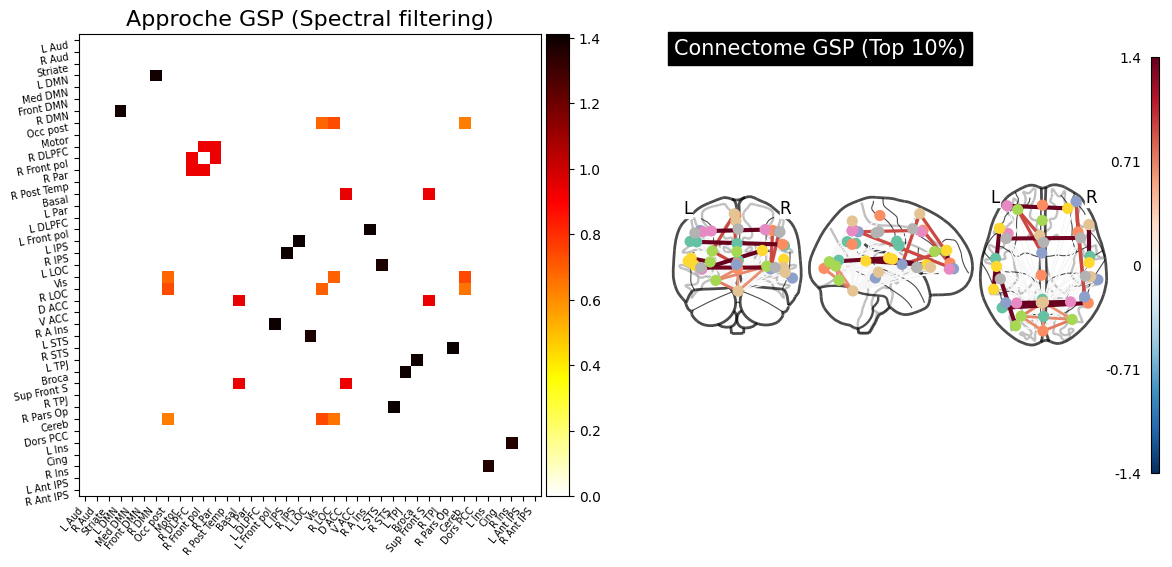

In [8]:
laplacian_matrix = result['L']
mask_diagonal = np.ones_like(laplacian_matrix) - np.identity(laplacian_matrix.shape[0])
adjacency_matrix = - laplacian_matrix*mask_diagonal


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plotting.plot_matrix(adjacency_matrix, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche GSP (Spectral filtering)")

plotting.plot_connectome(adjacency_matrix, atlas.region_coords, edge_threshold='90%', 
                         axes=axes[1], title="Connectome GSP (Top 10%)")
plt.show()